### Comparison of burstness statistics with surrogate

In [1]:
# Adding GDa to path
import sys
raw_path = '/home/vinicius/storage1/projects/GrayData-Analysis'
sys.path.insert(1, raw_path)
import GDa.stats.bursting                as     bst
from   GDa.stats.util                    import custom_mean, custom_std
from   GDa.session                       import session
from   GDa.temporal_network              import temporal_network
from   GDa.util                          import smooth

import seaborn                           as       sns
import numpy                             as       np
import xarray                            as       xr
import matplotlib.pyplot                 as       plt
import scipy.signal
import time
import os
import h5py

from   xfrites.conn.conn_coh             import conn_coherence_wav
from   tqdm                              import tqdm
from   sklearn.manifold                  import TSNE
from   scipy                             import stats

In [2]:
# Bands names
band_names  = [r'band 1', r'band 2', r'band 3', r'band 4', r'band 5']
stages      = ['baseline', 'cue', 'delay', 'match']

In [3]:
# Parameters to read the data
idx      = 3 
nses     = 1
nmonkey  = 0
align_to = 'cue'

dirs = { 'rawdata':os.path.join(raw_path, 'GrayLab'),
         'results':'Results/',
         'monkey' :['lucy', 'ethyl'],
         'session':'session01',
         'date'   :[['141014', '141015', '141205', '150128', '150211', '150304'], []] }

In [4]:
#  Instantiating session
ses   = session(raw_path = dirs['rawdata'], monkey = dirs['monkey'][nmonkey], date = dirs['date'][nmonkey][idx],
                session = nses, slvr_msmod = False, align_to = align_to, evt_dt = [-0.65, 3.00])
# Load data
ses.read_from_mat()

In [5]:
# Defining parameters
f_start, f_end, n_freqs, sfreq = .1, 80, 50, ses.data.attrs['fsample']
freqs = np.linspace(f_start, f_end, n_freqs, endpoint=True)
delta = 15 # Downsampling factor
mode  = 'morlet' # ("morlet", "mt_1", "mt_2")
if mode in ["morlet", "mt_1"]:
    foi   = np.array([
            [0.1, 6.],
            [6., 14.],
            [14., 26.],
            [26., 42.],
            [42., 80.]
                ])
    n_cycles     = freqs/2
    mt_bandwidth = None
    decim_at='tfd'
elif mode == "mt_2":
    foi   = np.array([
            [0.1, 6.],
            [6., 14.],
            [14., 26.],
            [26., 42.],
            [42., 80.]
                ])
    freqs = foi.mean(axis=1)
    W     = np.ceil( foi[:,1]-foi[:,0] )   # Bandwidth
    foi   = None     
    n_cycles     = np.array([3, 5, 9, 12, 16])
    mt_bandwidth = np.array([2, 4, 4.28, 5.647, 9.65])
    decim_at     = 'coh'

In [6]:
# Default threshold
kw  = dict(q=0.8, keep_weights=False)

# Store original and surrogate networks
net = []

# Original 
net +=  [temporal_network(coh_file='super_tensor.nc', monkey=dirs['monkey'][nmonkey], 
                          session=1, date='150128', trial_type=[1],
                          behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                          relative=True, verbose=True, **kw)]

# Surrogate same threshold as original
net +=  [temporal_network(coh_file='corr.nc', monkey=dirs['monkey'][nmonkey], 
                          session=1, date='150128', trial_type=[1], coh_thr=net[0].coh_thr,
                          behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                          relative=None, verbose=None, q=None)]

# Surrogate different threshold from original
net +=  [temporal_network(coh_file='super_tensor_0.nc', monkey=dirs['monkey'][nmonkey], 
                          session=1, date='150128', trial_type=[1], coh_thr=None,
                          behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                          relative=True, verbose=True, **kw)]

Computing coherence thresholds


100%|██████████| 5/5 [00:50<00:00, 10.03s/it]


Computing coherence thresholds


100%|██████████| 5/5 [00:51<00:00, 10.25s/it]


### Distribution of the thresholds

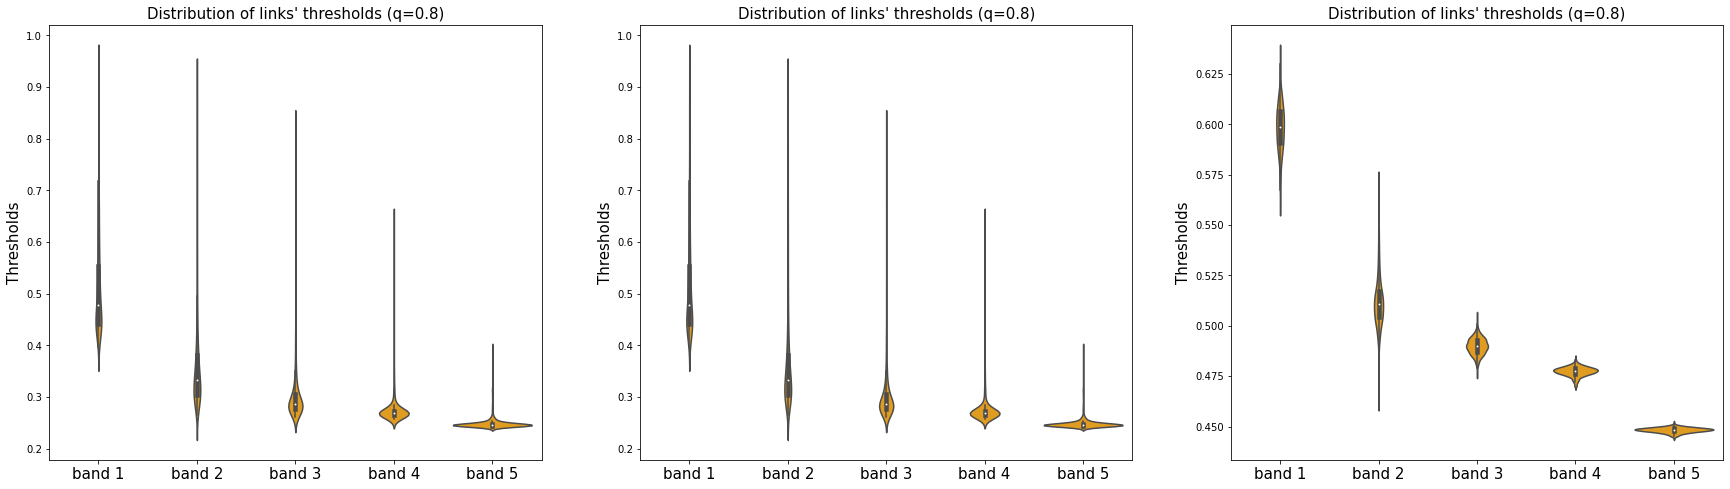

In [7]:
plt.figure(figsize=(30,8))
for i in range(len(net)):
    plt.subplot(1,3,i+1)
    sns.violinplot(data=net[i].coh_thr, color='orange')
    plt.title('Distribution of links\' thresholds (q=0.8)', fontsize=15);
    plt.xticks(range(len(band_names)), band_names, fontsize=15);
    plt.ylabel('Thresholds', fontsize=15);
    #plt.ylim([0.2,1]);

#### Burstness statistics

In [8]:
# Redefining masks
#net[n].create_stage_masks(flatten=False)

bs_stats = np.zeros((3,net[0].super_tensor.sizes['roi'],net[0].super_tensor.sizes['freqs'],len(stages), 4))

for n in tqdm( range(len(net)) ):

    n_samp = []
    for stage in stages:
        n_samp += [net[n].get_number_of_samples(stage=stage, total=True)]

    net[n].create_stage_masks(flatten=False)

    for i in range(len(band_names)):
        bs_stats[n,:,i,:,:] = bst.tensor_burstness_stats(net[n].super_tensor.isel(freqs=i).values, net[n].s_mask, 
                                                   drop_edges=True, samples=n_samp, 
                                                   dt=delta/net[n].super_tensor.attrs['fsample'], 
                                                   n_jobs=-1);

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 33%|███▎      | 1/3 [05:02<10:05, 302.66s/it]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 67%|██████▋   | 2/3 [10:04<05:02, 302.33s/it]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

  0%|          |  : 0/1176 [00:00<?,       ?it/s]

100%|██████████| 3/3 [15:08<00:00, 302.70s/it]


  0%|          | 0/3 [00:00<?, ?it/s]/home/vinicius/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/vinicius/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/vinicius/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/vinicius/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/vinicius/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/vinicius/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid val

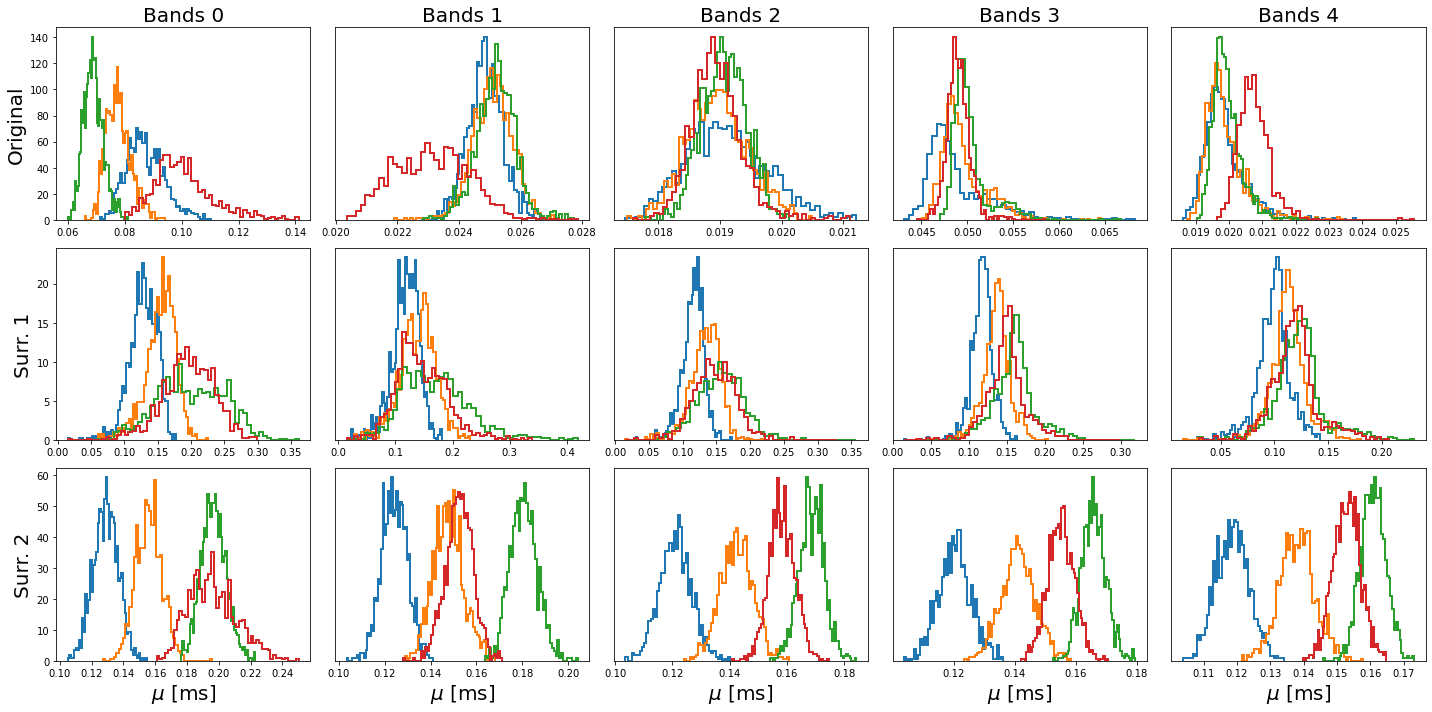

In [11]:
plt.figure(figsize=(20,10))
count = 1
#bins  = np.linspace(0.1,0.25,50)
ylbs  = ['Original', 'Surr. 1', 'Surr. 2']
for n in tqdm( range(len(net)) ):
    for i in range(net[0].super_tensor.sizes['freqs']):
        plt.subplot(len(net),net[0].super_tensor.sizes['freqs'], count)
        for s in range(len(stages)):
            plt.hist(bs_stats[n,:,i,s,0], bins=50, density=True, histtype='step', lw=2, fill=False)
            #plt.ylim([0,100])
            #if n<=1: plt.xticks([])
            if i>0: plt.yticks([])
        if i == 0: plt.ylabel(ylbs[n], fontsize=20)
        if n==0: plt.title(f'Bands {i}', fontsize=20)
        if n==2: plt.xlabel(r'$\mu$ [ms]', fontsize=20)
        count +=1
plt.tight_layout()

100%|██████████| 3/3 [00:00<00:00,  9.34it/s]


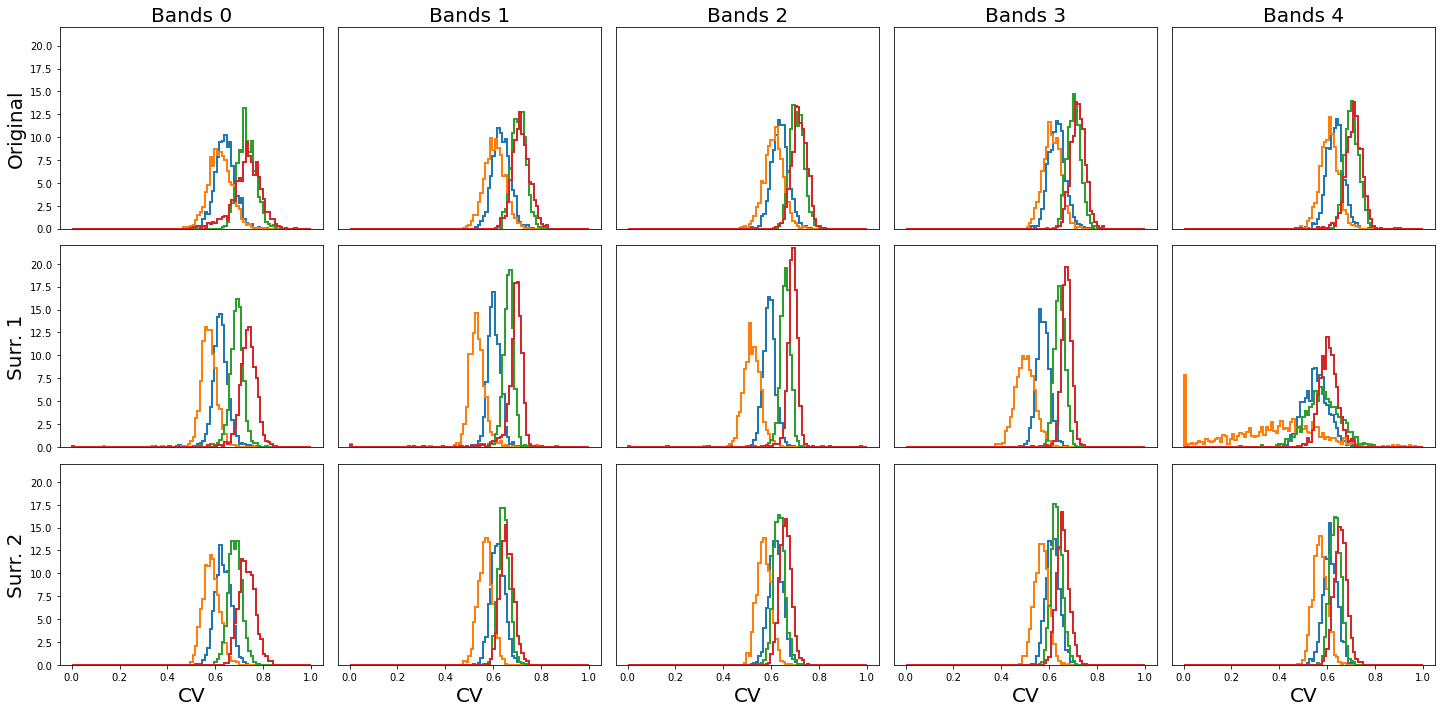

In [10]:
plt.figure(figsize=(20,10))
count = 1
bins  = np.linspace(0,1,100)
ylbs  = ['Original', 'Surr. 1', 'Surr. 2']
for n in tqdm( range(len(net)) ):
    for i in range(net[0].super_tensor.sizes['freqs']):
        plt.subplot(len(net),net[0].super_tensor.sizes['freqs'], count)
        for s in range(len(stages)):
            plt.hist(bs_stats[n,:,i,s,-1], bins=bins, density=True, histtype='step', lw=2, fill=False)
            plt.ylim([0,22])
            if n<=1: plt.xticks([])
            if i>0: plt.yticks([])
        if i == 0: plt.ylabel(ylbs[n], fontsize=20)
        if n==0: plt.title(f'Bands {i}', fontsize=20)
        if n==2: plt.xlabel('CV', fontsize=20)
        count +=1
plt.tight_layout()

 33%|███▎      | 1/3 [00:00<00:00,  3.92it/s]/home/vinicius/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/vinicius/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/vinicius/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/vinicius/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/vinicius/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/vinicius/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: inv

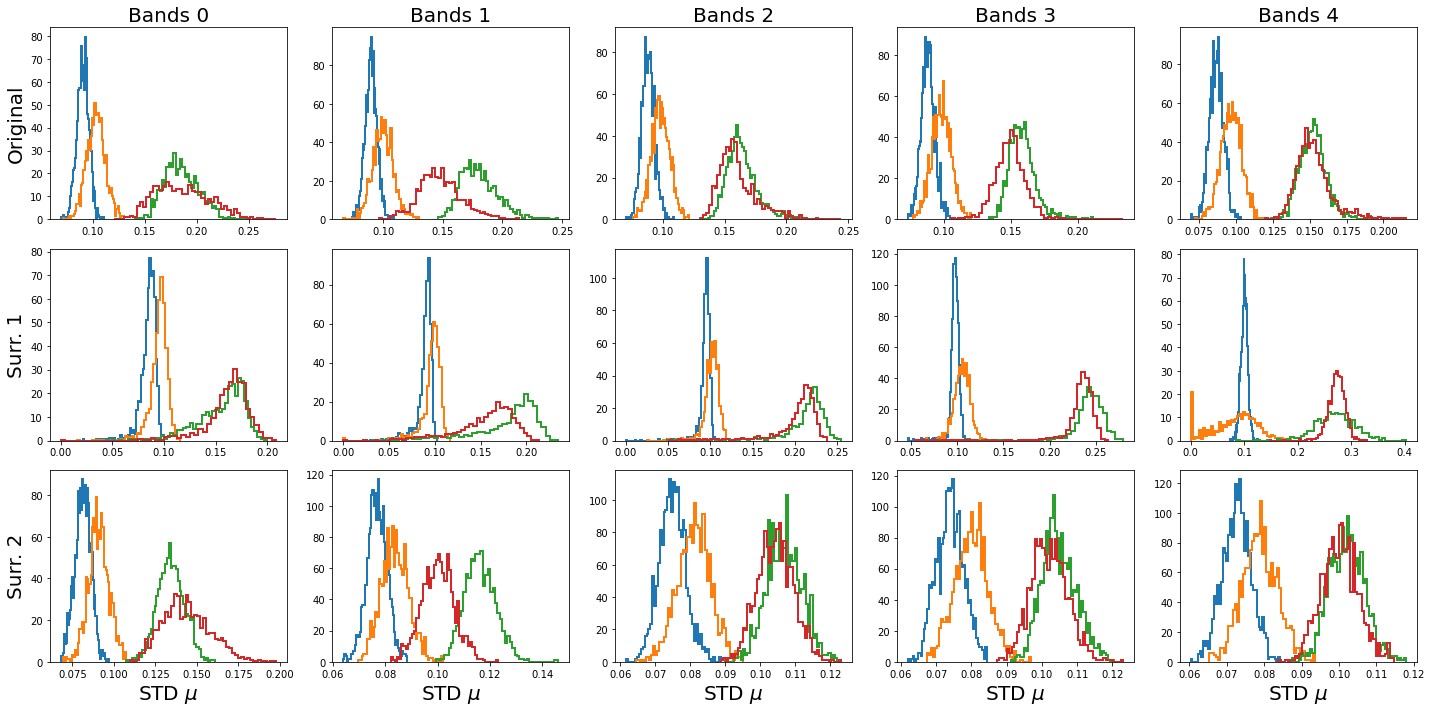

In [20]:
plt.figure(figsize=(20,10))
count = 1
bins  = 50#np.linspace(0,1,100)
ylbs  = ['Original', 'Surr. 1', 'Surr. 2']
for n in tqdm( range(len(net)) ):
    for i in range(net[0].super_tensor.sizes['freqs']):
        plt.subplot(len(net),net[0].super_tensor.sizes['freqs'], count)
        for s in range(len(stages)):
            plt.hist(bs_stats[n,:,i,s,1], bins=bins, density=True, histtype='step', lw=2, fill=False)
            #plt.ylim([0,22])
            #if n<=1: plt.xticks([])
            #if i>0: plt.yticks([])
        if i == 0: plt.ylabel(ylbs[n], fontsize=20)
        if n==0: plt.title(f'Bands {i}', fontsize=20)
        if n==2: plt.xlabel(r'STD $\mu$', fontsize=20)
        count +=1
plt.tight_layout()

### Mean burst duration scatter plot

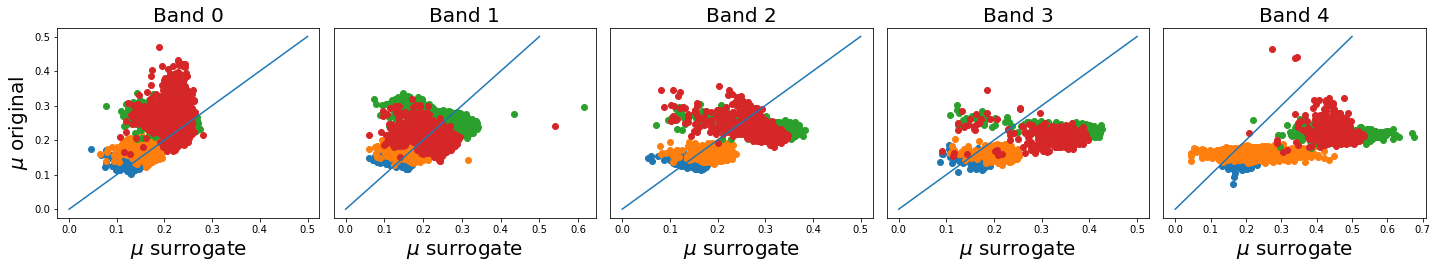

In [15]:
plt.figure(figsize=(20,10))
count = 1
bins  = np.linspace(0,1,100)
ylbs  = ['Original', 'Surr. 1', 'Surr. 2']
for i in range(net[0].super_tensor.sizes['freqs']):
    plt.subplot(len(net),net[0].super_tensor.sizes['freqs'], count)
    for s in range(len(stages)):
        plt.scatter(bs_stats[1,:,i,s,0], bs_stats[0,:,i,s,0], label=stages[s])
    x = np.linspace(0, .5, 1000)
    plt.plot(x,x)
    plt.title(f'Band {i}', fontsize=20)
    if n<=1: plt.xticks([])
    if i>0: plt.yticks([])
    if i==0: plt.ylabel(r'$\mu$ original', fontsize=20); #plt.legend(); 
    if n==0: plt.title(f'Bands {i}', fontsize=20)
    plt.xlabel(r'$\mu$ surrogate', fontsize=20)
    count +=1
plt.tight_layout()

### Total active time scatter plot

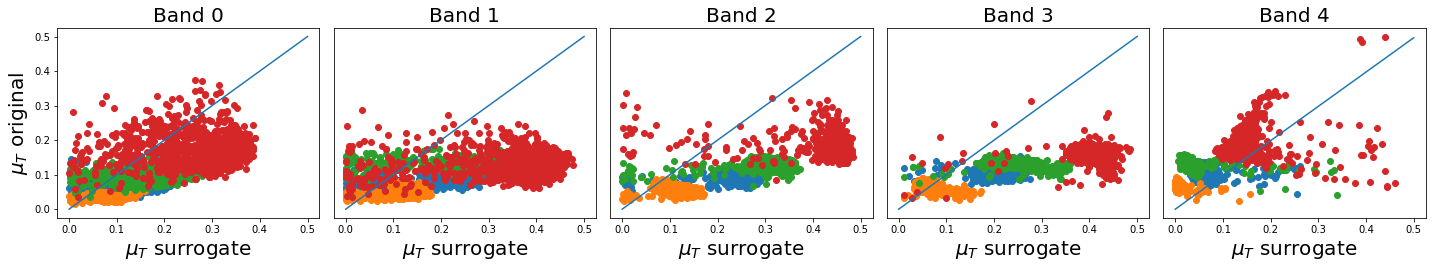

In [26]:
plt.figure(figsize=(20,10))
count = 1
bins  = np.linspace(0,1,100)
ylbs  = ['Original', 'Surr. 1', 'Surr. 2']
for i in range(net[0].super_tensor.sizes['freqs']):
    plt.subplot(len(net),net[0].super_tensor.sizes['freqs'], count)
    for s in range(len(stages)):
        plt.scatter(bs_stats[1,:,i,s,2], bs_stats[0,:,i,s,2], label=stages[s])
    x = np.linspace(0, .5, 1000)
    plt.plot(x,x)
    plt.title(f'Band {i}', fontsize=20)
    if n<=1: plt.xticks([])
    if i>0: plt.yticks([])
    if i==0: plt.ylabel(r'$\mu_T$ original', fontsize=20); #plt.legend(); 
    if n==0: plt.title(f'Bands {i}', fontsize=20)
    plt.xlabel(r'$\mu_T$ surrogate', fontsize=20)
    count +=1
plt.tight_layout()

### CV scatter plot

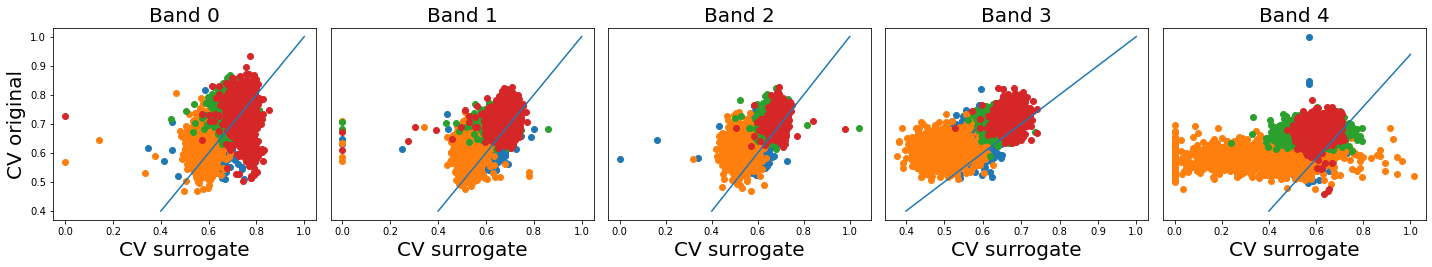

In [25]:
plt.figure(figsize=(20,10))
count = 1
bins  = np.linspace(0,1,100)
ylbs  = ['Original', 'Surr. 1', 'Surr. 2']
for i in range(net[0].super_tensor.sizes['freqs']):
    plt.subplot(len(net),net[0].super_tensor.sizes['freqs'], count)
    for s in range(len(stages)):
        plt.scatter(bs_stats[1,:,i,s,-1], bs_stats[0,:,i,s,-1], label=stages[s])
    x = np.linspace(0.4, 1, 1000)
    plt.plot(x,x)
    plt.title(f'Band {i}', fontsize=20)
    if n<=1: plt.xticks([])
    if i>0: plt.yticks([])
    if i==0: plt.ylabel('CV original', fontsize=20); #plt.legend(); 
    if n==0: plt.title(f'Bands {i}', fontsize=20)
    plt.xlabel('CV surrogate', fontsize=20)
    count +=1
plt.tight_layout()